# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#Refered/code-reusebility from ipynb from applied_ai_course notes 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId 
HAVING COUNT(*)>1
LIMIT 50000
""", con)

In [4]:
print(display.shape)
display.head(5)

(50000, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display['COUNT(*)'].sum()

242667

In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
WHERE UserId ='AZY10LLTJ71NX'
GROUP BY UserId 
HAVING COUNT(*)>1 
LIMIT 50000
""", con)
display.head()
#display[display['UserId']=='AZY10LLTJ71NX']


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
#Natural-Text-pre-processing 
#finding the which sentence contains html tags

import re

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;


2
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [15]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

stop = set(stopwords.words('english')) #set of stopwords

sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
sno.stem('delicious')
#stop


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SatyaKrishna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'delici'

In [16]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm import tqdm
import os

final_string=[] #creating a empty list for storing final preprocessed data
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[] #empty list for store after remove html and punc's and alfanumeric and words >2 and not in stop and converted to lowercase 
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)# above steps are stored here 
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews stored with above 
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews stored with above 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words stored in str1   
    final_string.append(str1) #here str1 stored in final_string
print("filtered sentences are stored successfully")


100%|███████████████████████████████████| 46071/46071 [01:09<00:00, 665.58it/s]


filtered sentences are stored successfully


In [17]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
print("cleaned data is added successfully in cleaned text feature")
#final = final.drop(columns = "Text")
final.shape
final.head(3)
#final.CleanedText.values[:50]

cleaned data is added successfully in cleaned text feature


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product avail www amazon com victor trap unrea...


In [18]:
#Random reviews after text pre-processing 
final.CleanedText[20]
final.CleanedText[500]
final.CleanedText[90]

'fed golden retriev hate wouldnt eat gave terribl diarrhea buy also super expens'

In [19]:
#all the filtered sentences and positive and negative reviews with bytes foramt for faster processing 
# are stored in final_string
#Now most common positive words and negitive words

freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words in review : ",freq_dist_positive.most_common(20))
print('-' *100)
print("Most Common Negative Words in review: ",freq_dist_negative.most_common(20))

Most Common Positive Words in review :  [(b'like', 17833), (b'tast', 15923), (b'good', 14331), (b'love', 14032), (b'flavor', 13822), (b'great', 13105), (b'one', 12248), (b'use', 11814), (b'tri', 11000), (b'product', 10803), (b'tea', 10602), (b'coffe', 10091), (b'get', 9179), (b'make', 9097), (b'food', 9089), (b'dog', 7456), (b'would', 7140), (b'time', 6847), (b'eat', 6785), (b'buy', 6753)]
----------------------------------------------------------------------------------------------------
Most Common Negative Words in review:  [(b'tast', 4739), (b'like', 4518), (b'product', 3596), (b'one', 2734), (b'flavor', 2640), (b'would', 2480), (b'tri', 2447), (b'use', 2018), (b'good', 1999), (b'get', 1922), (b'buy', 1821), (b'food', 1815), (b'coffe', 1795), (b'tea', 1676), (b'dog', 1662), (b'order', 1636), (b'dont', 1614), (b'even', 1562), (b'eat', 1428), (b'box', 1401)]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [20]:
## Similartly you can do preprocessing for review summary also.
#finding html tags in summary text 

j=0;
for summary in final['Summary'].values:
    if (len(re.findall('<.*?>', summary))):
        print(j)
        print(summary)
    else:
        print("There is no html tags")
        print('-'*50)
        break;
    j += 1;
final["Summary"].head(10)

There is no html tags
--------------------------------------------------


22620                                        made in china
22621                                    Dog Lover Delites
2546                                         thirty bucks?
2547                                          Flies Begone
1145                        WOW Make your own 'slickers' !
1146                                         Great Product
8696                  The Best Cleansing Tea I've Ever Had
8695                               Good, effective product
8694                         Best herbal tea for digestion
48736    They Secretly Switched The Coffee At My Favori...
Name: Summary, dtype: object

In [21]:
#removing if any html tags and punctuations in summary feature
#observed there is no html tags in summary attribute 

#def cleanhtml(s_sentence): #function to clean the word of any html-tags
#    s_cleanr = re.compile('<.*?>')
#    s_cleantext = re.sub(s_cleanr, ' ', s_sentence)
#    return s_cleantext

def cleanpunc(s_sentence): #function to clean the word of any punctuation or special characters
    s_cleaned = re.sub(r'[?|!|\'|"|#]',r'',s_sentence)
    s_cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',s_cleaned)
    return  s_cleaned

s_stop = set(stopwords.words('english')) #set of stopwords

s_sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
s_sno.stem('wow')

'wow'

In [22]:
summary_final_string=[] #creating a empty list for storing final preprocessed data
summary_all_positive_words=[] # store words from +ve summary here
summary_all_negative_words=[] # store words from -ve summary here.
for j, summary_sent in enumerate(tqdm(final['Summary'].values)):
    summary_filtered_sentence=[] #empty list for store after remove  punc's and alphanumeric and words >2 and not in stop and converted to lowercase 
    #summary_sent=cleanhtml(summary_sent) # remove HTMl tags
    for s_w in summary_sent.split():
        for s_cleaned_words in cleanpunc(s_w).split():
            if((s_cleaned_words.isalpha()) & (len(s_cleaned_words)>2)):    
                if(s_cleaned_words.lower() not in s_stop):
                    s_s=(s_sno.stem(s_cleaned_words.lower())).encode('utf8')
                    summary_filtered_sentence.append(s_s)# above steps are stored here 
                    if (final['Score'].values)[j] == 1: 
                        summary_all_positive_words.append(s_s) #list of all words used to describe positive summary stored with above 
                    if(final['Score'].values)[j] == 0:
                        summary_all_negative_words.append(s_s) #list of all words used to describe negative summary reviews stored with above 
    s_str1 = b" ".join(summary_filtered_sentence) #final string of cleaned words stored in s_str1   
    summary_final_string.append(s_str1) #here s_str1 stored in summary_final_string
print("filtered summary are stored successfully in summary_final_string")
len(summary_final_string)

100%|██████████████████████████████████| 46071/46071 [00:04<00:00, 9263.50it/s]


filtered summary are stored successfully in summary_final_string


46071

In [23]:
s_freq_dist_positive=nltk.FreqDist(summary_all_positive_words)
s_freq_dist_negative=nltk.FreqDist(summary_all_negative_words)
print("Most Common Positive Words in summary : ",s_freq_dist_positive.most_common(20))
print('-' *100)
print("Most Common Negative Words in summary : ",s_freq_dist_negative.most_common(20))

Most Common Positive Words in summary :  [(b'great', 5948), (b'good', 3834), (b'love', 3104), (b'best', 2801), (b'tea', 1785), (b'tast', 1762), (b'dog', 1687), (b'coffe', 1604), (b'delici', 1585), (b'product', 1412), (b'excel', 1135), (b'flavor', 1075), (b'yummi', 921), (b'tasti', 881), (b'food', 878), (b'like', 833), (b'favorit', 813), (b'price', 809), (b'treat', 792), (b'ever', 733)]
----------------------------------------------------------------------------------------------------
Most Common Negative Words in summary :  [(b'tast', 608), (b'good', 368), (b'like', 360), (b'flavor', 240), (b'disappoint', 235), (b'bad', 233), (b'product', 226), (b'dog', 222), (b'dont', 188), (b'great', 169), (b'coffe', 167), (b'buy', 159), (b'price', 136), (b'tea', 127), (b'aw', 125), (b'horribl', 122), (b'terribl', 115), (b'made', 114), (b'food', 110), (b'yuck', 109)]


In [24]:
final['Cleanedsummary']=summary_final_string
final[0:1]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleanedsummary
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...,b'made china'


In [25]:
#splitting the cleaned text and score to train, cv,test
from sklearn import model_selection
from sklearn.model_selection import train_test_split

#here we splitting the whole data to train test and cv
x_bow=final['CleanedText'] #taking whole data
y_bow=final['Score']
#splitted the data in to train and test
x_bow_train,x_bow_test_data,y_bow_train,y_bow_test_data = train_test_split(x_bow, y_bow, test_size=0.3, random_state=0)
#splitted the above train data into 2nd train and cross validation 
x_bow_train_data,x_bow_cv_data,y_bow_train_data,y_bow_cv_data = train_test_split(x_bow_train, y_bow_train, test_size=0.3, random_state=0)

print("Data splitted sucessfully in to train ,test,cv")

Data splitted sucessfully in to train ,test,cv


# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
#APPLYING_BOW ON TRAIN2 DATA ONLY 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

count_vect = CountVectorizer() #in scikit-learn
final_counts_bow_train = count_vect.fit_transform(x_bow_train_data.values)
final_bow_train_data=final_counts_bow_train
#transform  on testdata
final_bow_test_data = count_vect.transform(x_bow_test_data)
#transform on cv data 
final_bow_cv_data = count_vect.transform(x_bow_cv_data)

print("the type of count vectorizer ",type(final_bow_train_data))
print("the shape of out text BOW vectorizer ",final_bow_train_data.get_shape())
print("the number of unique words ", final_bow_train_data.get_shape()[1])
#dense_bow=final_bow_train_data.todense()
print('-' * 50 )
print("here below  we converting scipy to dense for knn ")
print('-' * 50 )
#print("the type of count vectorizer ",type(dense_bow))

print(final_bow_train_data.shape,y_bow_train_data.shape)
print(final_bow_test_data.shape,y_bow_test_data.shape)
print(final_bow_cv_data.shape,y_bow_cv_data.shape)
print("Bow splitted data\n", "final_bow_train_data,y_bow_train_data\n","final_bow_test_data,y_bow_test_data\n","final_bow_cv_data,y_bow_cv_data\n")

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (22574, 18087)
the number of unique words  18087
--------------------------------------------------
here below  we converting scipy to dense for knn 
--------------------------------------------------
(22574, 18087) (22574,)
(13822, 18087) (13822,)
(9675, 18087) (9675,)
Bow splitted data
 final_bow_train_data,y_bow_train_data
 final_bow_test_data,y_bow_test_data
 final_bow_cv_data,y_bow_cv_data



## [4.2] Bi-Grams and n-Grams.

In [27]:
#UNI_GRAMS-BI_GRAMS-TRI_GRAMS
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn range will choose how many grams we want here we choose 1 and 2 means uni and bi and n it will be tri and so..onnn 
final_bigram_counts = count_vect.fit_transform(x_bow_train_data.values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])
#bi_gram=final_bigram_counts.todense()
#print('-' * 50 )
#print("here below  we converting scipy to dense  ")
#print('-' * 50 )
#print("the type of count vectorizer ",type(bi_gram))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (22574, 425298)
the number of unique words including both unigrams and bigrams  425298


## [4.3] TF-IDF

In [28]:
#TF-IDF_Vectorizer
x_tfidf=final['CleanedText'] #taking whole data
y_tfidf=final['Score']
#splitted the data in to train and test
x_tfidf_train,x_tfidf_test_data,y_tfidf_train,y_tfidf_test_data = train_test_split(x_tfidf, y_tfidf, test_size=0.3, random_state=0)
#splitted the above train data into 2nd train and cross validation 
x_tfidf_train_data,x_tfidf_cv_data,y_tfidf_train_data,y_tfidf_cv_data = train_test_split(x_tfidf_train, y_tfidf_train, test_size=0.3, random_state=0)

print("Data splitted sucessfully in to train ,test,cv")

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tfidf_train_data = tf_idf_vect.fit_transform(x_tfidf_train_data.values)
final_tfidf_test_data = tf_idf_vect.transform(x_tfidf_test_data)
final_tfidf_cv_data = tf_idf_vect.transform(x_tfidf_cv_data)
print("the type of count vectorizer ",type(final_tfidf_train_data))
print("the shape of out text TFIDF vectorizer ",final_tfidf_train_data.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tfidf_train_data.get_shape()[1])
#tfidf_dense=final_tfidf_train_data.todense()
#print('-' * 50 )
#print("here below  we converting scipy to dense ")
#print('-' * 50 )
#print("the type of count vectorizer ",type(tfidf_dense))


Data splitted sucessfully in to train ,test,cv
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (22574, 425298)
the number of unique words including both unigrams and bigrams  425298


## [4.4] Word2Vec

In [29]:
x_avgw2v=final['CleanedText'] #taking whole data
y_avgw2v=final['Score']
#splitted the data in to train and test
x_avgw2v_train,x_avgw2v_test_data,y_avgw2v_train,y_avgw2v_test_data = train_test_split(x_avgw2v, y_avgw2v, test_size=0.3, random_state=0)
#splitted the above train data into 2nd train and cross validation 
x_avgw2v_train_data,x_avgw2v_cv_data,y_avgw2v_train_data,y_avgw2v_cv_data = train_test_split(x_avgw2v_train, y_avgw2v_train, test_size=0.3, random_state=0)

print("avgw2v Data splitted sucessfully in to train ,test,cv")


# Train your own Word2Vec model using your own text corpus
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#train data
cleantext_train= x_avgw2v_train_data # building own text corpus from w2v train data  
i=0
list_of_sentance_train=[]
for sentance_train in cleantext_train:
    list_of_sentance_train.append(sentance_train.split())
print("cleantext train data")
    
#cv data
cleantext_cv= x_avgw2v_cv_data # building own text corpus from w2v cv data  
j=0
list_of_sentance_cv=[]
for sentance_cv in cleantext_cv:
    list_of_sentance_cv.append(sentance_cv.split())
print("cleantext cv data")


#test data
cleantext_test= x_avgw2v_test_data # building own text corpus from w2v test data  
k=0
list_of_sentance_test=[]
for sentance_test in cleantext_test:
    list_of_sentance_test.append(sentance_test.split())
print("cleantext test data")

avgw2v Data splitted sucessfully in to train ,test,cv
cleantext train data
cleantext cv data
cleantext test data


In [30]:
#WORD2VEC USING OWN CORPUS FROM ABOVE DATA 
# min_count = 5 considers only words that occured atleast 5 times
w2v_train_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
#w2v_cv_model=Word2Vec(list_of_sentance_cv,min_count=5,size=50, workers=4)
#w2v_test_model=Word2Vec(list_of_sentance_test,min_count=5,size=50, workers=4)

w2v_train_model.wv.most_similar('like')  

[('prefer', 0.7352312803268433),
 ('weird', 0.705997884273529),
 ('appeal', 0.6820189952850342),
 ('strang', 0.673439085483551),
 ('bland', 0.6719467639923096),
 ('nasti', 0.6702864170074463),
 ('except', 0.6640591621398926),
 ('unlik', 0.6578013300895691),
 ('gross', 0.6554428339004517),
 ('bud', 0.6487538814544678)]

In [31]:
#w2v_cv_model.wv.most_similar('like')

In [32]:
#w2v_test_model.wv.most_similar('like')

In [33]:
w2v_words_train = list(w2v_train_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words from corpus  ", w2v_words_train[0:50])

number of words that occured minimum 5 times  6401
sample words from corpus   ['favorit', 'nut', 'snack', 'sunflow', 'absolut', 'almond', 'cashew', 'butteri', 'rich', 'realli', 'great', 'given', 'gift', 'everyon', 'follow', 'ask', 'buy', 'kiddo', 'stay', 'long', 'hour', 'school', 'ive', 'look', 'bring', 'arent', 'unhealthi', 'found', 'fig', 'newton', 'mini', 'pretti', 'excit', 'sinc', 'love', 'full', 'size', 'theyr', 'smaller', 'cours', 'much', 'less', 'fruit', 'fill', 'still', 'delici', 'individu', 'bag', 'quit', 'small']


In [34]:
#w2v_words_cv = list(w2v_cv_model.wv.vocab)
#print("number of words that occured minimum 5 times ",len(w2v_words_cv))
#print("sample words from corpus  ", w2v_words_cv[0:50])

In [35]:
#w2v_words_test = list(w2v_test_model.wv.vocab)
#print("number of words that occured minimum 5 times ",len(w2v_words_test))
#print("sample words from corpus  ", w2v_words_test[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [36]:
# average Word2Vec train data 
# compute average word2vec_train for each review.
sent_vectors_train = []; # the avg-w2v_train for each sentence/review is stored in this list
final_avgw2v_train_data=sent_vectors_train
for sent_train in tqdm(list_of_sentance_train): # for each train_review/sentence
    sent_vec_train = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_train =0; # num of words with a valid vector in the train_sentence/review
    for word_train in sent_train: # for each word in a train_review/sentence
        if word_train in w2v_words_train:
            vec_train = w2v_train_model.wv[word_train]
            sent_vec_train += vec_train
            cnt_words_train += 1
    if cnt_words_train != 0:
        sent_vec_train /= cnt_words_train
    sent_vectors_train.append(sent_vec_train)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))
print(type(sent_vectors_train))

100%|███████████████████████████████████| 22574/22574 [00:23<00:00, 954.30it/s]


22574
50
<class 'list'>


In [37]:
# average Word2Vec cv data 
# compute average word2vec_train for each review.
sent_vectors_cv = []; # the avg-cv for each sentence/review is stored in this list
final_avgw2v_cv_data=sent_vectors_cv
for sent_cv in tqdm(list_of_sentance_cv): # for each train_review/sentence
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_cv =0; # num of words with a valid vector in the train_sentence/review
    for word_cv in sent_cv: # for each word in a train_review/sentence
        if word_cv in w2v_words_train:
            vec_cv = w2v_train_model.wv[word_cv]
            sent_vec_cv += vec_cv
            cnt_words_cv += 1
    if cnt_words_cv != 0:
        sent_vec_cv /= cnt_words_cv
    sent_vectors_cv.append(sent_vec_cv)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))
print(type(sent_vectors_cv))

100%|█████████████████████████████████████| 9675/9675 [00:10<00:00, 884.92it/s]


9675
50
<class 'list'>


In [38]:
# average Word2Vec test data 
# compute average word2vec_train for each review.
sent_vectors_test = []; # the avg-w2v_train for each sentence/review is stored in this list
final_avgw2v_test_data=sent_vectors_test
for sent_test in tqdm(list_of_sentance_test): # for each train_review/sentence
    sent_vec_test = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_test =0; # num of words with a valid vector in the train_sentence/review
    for word_test in sent_test: # for each word in a train_review/sentence
        if word_test in w2v_words_train:
            vec_test = w2v_train_model.wv[word_test]
            sent_vec_test += vec_test
            cnt_words_test += 1
    if cnt_words_test != 0:
        sent_vec_test /= cnt_words_test
    sent_vectors_test.append(sent_vec_test)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))
print(type(sent_vectors_test))

100%|███████████████████████████████████| 13822/13822 [00:14<00:00, 945.19it/s]


13822
50
<class 'list'>


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
x_tfidfw2v=final['CleanedText'] #taking whole data
y_tfidfw2v=final['Score']
#splitted the whole data in to train and test
x_tfidfw2v_train,x_tfidfw2v_test_data,y_tfidfw2v_train,y_tfidfw2v_test_data = train_test_split(x_tfidfw2v, y_tfidfw2v, test_size=0.3, random_state=0)
#splitted the above train data into 2nd train and cross validation 
x_tfidfw2v_train_data,x_tfidfw2v_cv_data,y_tfidfw2v_train_data,y_tfidfw2v_cv_data = train_test_split(x_tfidfw2v_train, y_tfidfw2v_train, test_size=0.3, random_state=0)

print("tfidfw2v Data splitted sucessfully in to train ,test,cv")

tfidfw2v Data splitted sucessfully in to train ,test,cv


In [40]:
#tfidf_traindata using  train model
tfidfw2v_model_train = TfidfVectorizer()
final_tfidfw2v_train=tfidfw2v_model_train.fit(x_tfidfw2v_train_data)
dictionary_train = dict(zip(final_tfidfw2v_train.get_feature_names(), list(final_tfidfw2v_train.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat_train = final_tfidfw2v_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = [];# the tfidf-w2v for each sentence/review is stored in this list
final_tfidfw2v_train_data=tfidf_sent_vectors_train
row=0;
for sent_train in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec_train = np.zeros(50) # as word vectors are of zero length
    weight_sum_train =0; # num of words with a valid vector in the sentence/review
    for word in sent_train: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_train:
            vec_train = w2v_train_model.wv[word]
             #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_train = dictionary_train[word]*(sent_train.count(word)/len(sent_train))
            sent_vec_train += (vec_train * tf_idf_train)
            weight_sum_train += tf_idf_train
    if weight_sum_train != 0:
        sent_vec_train /= weight_sum_train
    tfidf_sent_vectors_train.append(sent_vec_train)
    row += 1
print(len(sent_vec_train))
print(len(tfidf_sent_vectors_train))  
print(type(tfidf_sent_vectors_train))  

100%|███████████████████████████████████| 22574/22574 [03:19<00:00, 112.44it/s]


50
22574
<class 'list'>


In [41]:
#tfidf_cv_data using  train model
tfidfw2v_model_train = TfidfVectorizer()
final_tfidfw2v_train=tfidfw2v_model_train.fit(x_tfidfw2v_train_data)
dictionary_train = dict(zip(final_tfidfw2v_train.get_feature_names(), list(final_tfidfw2v_train.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat_cv = final_tfidfw2v_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = [];# the tfidf-w2v for each sentence/review is stored in this list
final_tfidfw2v_cv_data=tfidf_sent_vectors_cv
row=0;
for sent_cv in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length
    weight_sum_cv =0; # num of words with a valid vector in the sentence/review
    for word_cv in sent_cv: # for each word in a review/sentence
        if word_cv in w2v_words_train and word_cv in tfidf_feat_cv:
            vec_cv = w2v_train_model.wv[word_cv]
             #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_cv = dictionary_train[word_cv]*(sent_cv.count(word_cv)/len(sent_cv))
            sent_vec_cv += (vec_cv * tf_idf_cv)
            weight_sum_cv += tf_idf_cv
    if weight_sum_cv != 0:
        sent_vec_cv /= weight_sum_cv
    tfidf_sent_vectors_cv.append(sent_vec_cv)
    row += 1
print(len(sent_vec_cv))
print(len(tfidf_sent_vectors_cv))  
print(type(tfidf_sent_vectors_cv))  

100%|██████████████████████████████████████| 9675/9675 [01:40<00:00, 96.18it/s]


50
9675
<class 'list'>


In [42]:
#tfidf_test_data using  train model
tfidfw2v_model_train = TfidfVectorizer()
final_tfidfw2v_train=tfidfw2v_model_train.fit(x_tfidfw2v_train_data)
dictionary_train = dict(zip(final_tfidfw2v_train.get_feature_names(), list(final_tfidfw2v_train.idf_)))

#tfidfw2v on test data 
tfidf_feat_test = final_tfidfw2v_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
final_tfidfw2v_test_data=tfidf_sent_vectors_test
row=0;
for sent_test in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec_test = np.zeros(50) # as word vectors are of zero length
    weight_sum_test =0; # num of words with a valid vector in the sentence/review
    for word_test in sent_test: # for each word in a review/sentence
        if word_test in w2v_words_train and word_test in tfidf_feat_test:
            vec_test = w2v_train_model.wv[word_test]
             #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_test = dictionary_train[word_test]*(sent_test.count(word_test)/len(sent_test))
            sent_vec_test += (vec_test * tf_idf_test)
            weight_sum_test += tf_idf_test
    if weight_sum_test != 0:
        sent_vec_test /= weight_sum_test
    tfidf_sent_vectors_test.append(sent_vec_test)
    row += 1
print(len(sent_vec_test))
print(len(tfidf_sent_vectors_test))  
print(type(tfidf_sent_vectors_test))  

100%|████████████████████████████████████| 13822/13822 [02:57<00:00, 77.84it/s]


50
13822
<class 'list'>


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [43]:
print("Bow splitted data\n", "final_bow_train_data,y_bow_train_data\n","final_bow_test_data,y_bow_test_data\n","final_bow_cv_data,y_bow_cv_data\n")
listnu= list(range(1,100,8))
print(listnu)
print("cv data\n",y_bow_cv_data.value_counts())
print("train data\n",y_bow_train_data.value_counts())
print("test data\n",y_bow_test_data.value_counts())

Bow splitted data
 final_bow_train_data,y_bow_train_data
 final_bow_test_data,y_bow_test_data
 final_bow_cv_data,y_bow_cv_data

[1, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 97]
cv data
 1    8075
0    1600
Name: Score, dtype: int64
train data
 1    18823
0     3751
Name: Score, dtype: int64
test data
 1    11581
0     2241
Name: Score, dtype: int64


In [44]:
# Please write all the code with proper documentation
#finding the best hypermeter with bow train and cv data 
#loading library's
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
import random
from sklearn import metrics
from sklearn.metrics import roc_auc_score

#finding the best hyper parameter  using simple loop method 
# Reference ,code re-using from sample solution ipynb
train_auc = []
cv_auc = []
K = list(range(1,100,8))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(final_bow_train_data, y_bow_train_data)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(final_bow_train_data)[:,1]
    y_cv_pred =  neigh.predict_proba(final_bow_cv_data)[:,1]
    train_auc_score=roc_auc_score(y_bow_train_data,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_bow_cv_data, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("k=",i,"cv:",cv_auc_score,"train:",train_auc_score)

k= 1 cv: 0.5872968266253871 train: 1.0
k= 9 cv: 0.7115060758513931 train: 0.8687464921961061
k= 17 cv: 0.7432191176470586 train: 0.8452193158981648
k= 25 cv: 0.7560878482972136 train: 0.8365185105041957
k= 33 cv: 0.7628345588235295 train: 0.8331837926150149
k= 41 cv: 0.7752842879256966 train: 0.8306447186875652
k= 49 cv: 0.7806054179566564 train: 0.8290223848362849
k= 57 cv: 0.7834969040247677 train: 0.8281658812249936
k= 65 cv: 0.7892736842105262 train: 0.82871483611383
k= 73 cv: 0.7935981037151703 train: 0.8278455288899708
k= 81 cv: 0.794989705882353 train: 0.826772617316039
k= 89 cv: 0.7960210526315789 train: 0.825983481385254
k= 97 cv: 0.7983856037151703 train: 0.8251397318150214


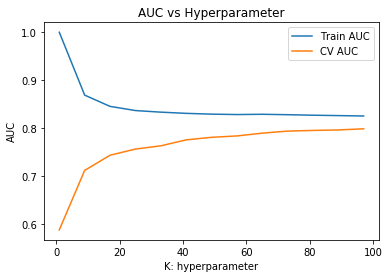

In [45]:
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

We got auc scores from cv data it seems 9 be the optimal k after 9 there is not much change in auc scores ,so here considering K=9 be the optimal k 

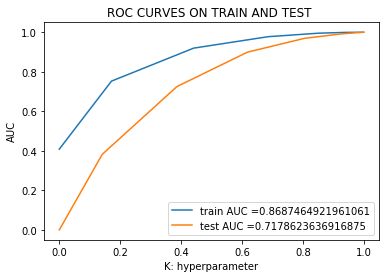

In [46]:
#applying  knn brute version on bow train  data and predicting with bow test data 
from sklearn.metrics import roc_curve, auc

neigh = KNeighborsClassifier(n_neighbors=9,algorithm = 'brute')
neigh.fit(final_bow_train_data, y_bow_train_data)


bow_train_fpr, bow_train_tpr, bow_thresholds = roc_curve(y_bow_train_data, neigh.predict_proba(final_bow_train_data)[:,1])
bow_test_fpr, bow_test_tpr, bow_thresholds = roc_curve(y_bow_test_data, neigh.predict_proba(final_bow_test_data)[:,1])

plt.plot(bow_train_fpr, bow_train_tpr, label="train AUC ="+str(auc(bow_train_fpr, bow_train_tpr)))
plt.plot(bow_test_fpr, bow_test_tpr, label="test AUC ="+str(auc(bow_test_fpr, bow_test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

Test confusion matrix
[[  160    94]
 [ 2081 11487]]


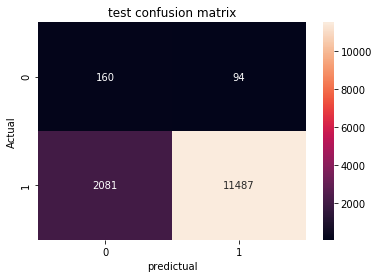

In [47]:
#Test data confusion matrix 
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
cm_test = confusion_matrix(neigh.predict(final_bow_test_data),y_bow_test_data)
sns.heatmap(cm_test, annot=True, fmt="d")
plt.title("test confusion matrix")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(cm_test)

<h3><b>OBSERVATIONS IN BOW DATA USING KNN BRUTE</b></h3>
 auc value of train is 0.86 and auc value of test is 0.71 ,Confusion marix says out of 13822 points in test data 11467 are correctly predicted reamining 2175 are in-correctly predicted 

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

k= 1 CV: 0.6278163699690402 Train: 1.0
k= 9 CV: 0.7804244582043343 Train: 0.9022468753767877
k= 17 CV: 0.8116580882352941 Train: 0.886834215156183
k= 25 CV: 0.8284724458204334 Train: 0.883168713670192
k= 33 CV: 0.8391020897832817 Train: 0.8818341141011213
k= 41 CV: 0.8467662151702786 Train: 0.8803109799206638
k= 49 CV: 0.8501160216718265 Train: 0.8806711665038573
k= 57 CV: 0.8511613390092879 Train: 0.8810833535998185
k= 65 CV: 0.8546837074303406 Train: 0.8819011206177777
k= 73 CV: 0.8579023606811146 Train: 0.8823152976557364
k= 81 CV: 0.8607553018575851 Train: 0.8827505921564587
k= 89 CV: 0.8633921052631579 Train: 0.8833237875131155
k= 97 CV: 0.8649589396284829 Train: 0.8832673468094849


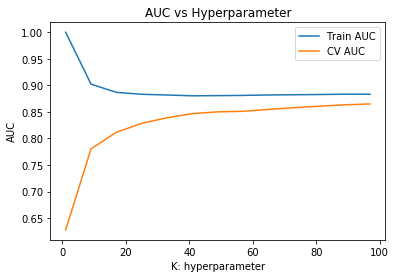

In [48]:
#finding the best hyper parameter  using simple loop method 
# Reference ,code re-using from sample solution ipynb
#Finding the best hypermeter using tfidf train and cv 
train_auc = []
cv_auc = []
K = list(range(1,100,8))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(final_tfidf_train_data, y_tfidf_train_data)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(final_tfidf_train_data)[:,1]
    y_cv_pred =  neigh.predict_proba(final_tfidf_cv_data)[:,1]
    train_auc_score=roc_auc_score(y_tfidf_train_data,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_tfidf_cv_data, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("k=",i,"CV:",cv_auc_score,"Train:",train_auc_score)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

There is not much change after k=17 on tfidf data so here we consider optimal k as k=17 

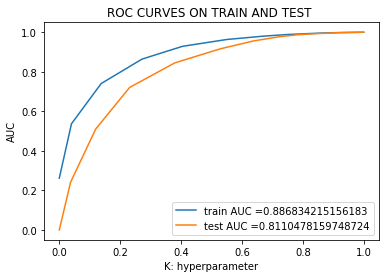

In [49]:
#applying  knn brute version on tfidf train data and predicitng with tfidf test data

neigh = KNeighborsClassifier(n_neighbors=17,algorithm = 'brute')
neigh.fit(final_tfidf_train_data, y_tfidf_train_data)


tfidf_train_fpr, tfidf_train_tpr, tfidf_thresholds = roc_curve(y_tfidf_train_data, neigh.predict_proba(final_tfidf_train_data)[:,1])
tfidf_test_fpr, tfidf_test_tpr, tfidf_thresholds = roc_curve(y_tfidf_test_data, neigh.predict_proba(final_tfidf_test_data)[:,1])
#plottig ROC curves both train and test 
plt.plot(tfidf_train_fpr, tfidf_train_tpr, label="train AUC ="+str(auc(tfidf_train_fpr, tfidf_train_tpr)))
plt.plot(tfidf_test_fpr, tfidf_test_tpr, label="test AUC ="+str(auc(tfidf_test_fpr, tfidf_test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

TFIDF Test confusion matrix
[[  356    86]
 [ 1885 11495]]


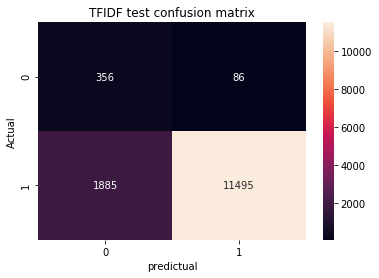

In [50]:
#TFIDf Test data confusion matrix
print("TFIDF Test confusion matrix")
tfidf_cm_test = confusion_matrix(neigh.predict(final_tfidf_test_data),y_tfidf_test_data)
sns.heatmap(tfidf_cm_test, annot=True, fmt="d")
plt.title("TFIDF test confusion matrix")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidf_cm_test)

<h2><b>OBSERVATIONS TFIDF USING KNN BRUTE</b></h2><br>
In TFIDF data the auc values are closer to each other train auc is 0.88 and test auc is 0.81 which is good performance prediction is also good ,in confusion matrix out of 13822 points of tfidf data 11851 are correctly predicted both positives and negatives and 1971 are in-correctly predicted both positives and negatives 

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

k =  1 CV: 0.6637983746130032 Train: 1.0
k =  9 CV: 0.82695576625387 Train: 0.9153419825796372
k =  17 CV: 0.8484204334365325 Train: 0.902882346711829
k =  25 CV: 0.8551335913312693 Train: 0.8948622926853995
k =  33 CV: 0.8589477941176471 Train: 0.8912053883153694
k =  41 CV: 0.8624748839009287 Train: 0.8890075504914497
k =  49 CV: 0.8651991486068112 Train: 0.8861079358986004
k =  57 CV: 0.8650543730650155 Train: 0.8844266544416717
k =  65 CV: 0.8661979102167183 Train: 0.8830986903731407
k =  73 CV: 0.8668851780185758 Train: 0.8811318699436794
k =  81 CV: 0.8669831269349846 Train: 0.8804039406630173
k =  89 CV: 0.8684696981424148 Train: 0.879935879394955
k =  97 CV: 0.8684740325077399 Train: 0.8792437124170951


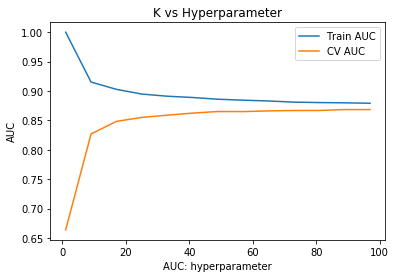

In [51]:
#finding the best hyper parameter  using train and cv data with simple loop method 
# Reference ,code re-using from sample solution ipynb
train_auc = []
cv_auc = []
K = list(range(1,100,8))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(final_avgw2v_train_data, y_avgw2v_train_data)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(final_avgw2v_train_data)[:,1]
    y_cv_pred =  neigh.predict_proba(final_avgw2v_cv_data)[:,1]
    train_auc_score=roc_auc_score(y_avgw2v_train_data,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_avgw2v_cv_data, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("k = ",i,"CV:",cv_auc_score,"Train:",train_auc_score)
#plotting auc scores both train data and cv data
plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("AUC: hyperparameter")
plt.ylabel("AUC")
plt.title("K vs Hyperparameter")
plt.show()

There is not much change after k=9 on Avgw2v data so here we consider optimal k as k=9 

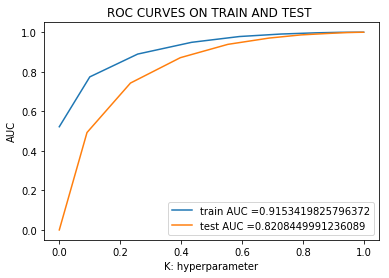

In [52]:
#applying  knn brute version on avgw2v data

neigh = KNeighborsClassifier(n_neighbors=9,algorithm = 'brute')
neigh.fit(final_avgw2v_train_data, y_avgw2v_train_data)


avgw2v_train_fpr, avgw2v_train_tpr, avgw2v_thresholds = roc_curve(y_avgw2v_train_data, neigh.predict_proba(final_avgw2v_train_data)[:,1])
avgw2v_test_fpr, avgw2v_test_tpr, avgw2v_thresholds = roc_curve(y_avgw2v_test_data, neigh.predict_proba(final_avgw2v_test_data)[:,1])

plt.plot(avgw2v_train_fpr, avgw2v_train_tpr, label="train AUC ="+str(auc(avgw2v_train_fpr, avgw2v_train_tpr)))
plt.plot(avgw2v_test_fpr, avgw2v_test_tpr, label="test AUC ="+str(auc(avgw2v_test_fpr, avgw2v_test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

avgw2v Test confusion matrix
[[  696   341]
 [ 1545 11240]]


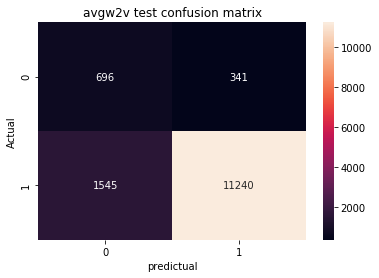

In [53]:
#avgw2v Test data confusion matrix
print("avgw2v Test confusion matrix")
avgw2v_cm_test = confusion_matrix(neigh.predict(final_avgw2v_test_data),y_avgw2v_test_data)
sns.heatmap(avgw2v_cm_test, annot=True, fmt="d")
plt.title("avgw2v test confusion matrix")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(avgw2v_cm_test)

<h2><b>OBSERVATIONS IN AVGW2V USING KNN BRUTE</b></h2><br>
here we got confsion matrix 11936 are correctly predicted and 1886 are wrongly predicted and we got cv auc as 0.82 at k= 9 and test auc is 0.82 and train auc is 0.91 which is goog performance 

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [54]:
'''print("TFIDFW2V data in train cv and test ")
print("-"*50)
print("final_tfidfw2v_train_data, y_tfidfw2v_train_data")
print("final_tfidfw2v_cv_data, y_tfidfw2v_cv_data")
print("final_tfidfw2v_test_data, y_tfidfw2v_test_data")'''

'print("TFIDFW2V data in train cv and test ")\nprint("-"*50)\nprint("final_tfidfw2v_train_data, y_tfidfw2v_train_data")\nprint("final_tfidfw2v_cv_data, y_tfidfw2v_cv_data")\nprint("final_tfidfw2v_test_data, y_tfidfw2v_test_data")'

k =  1 CV: 0.6379982585139319 Train: 1.0
k =  9 CV: 0.7897195046439628 Train: 0.8977872170743312
k =  17 CV: 0.812828366873065 Train: 0.8821173232127385
k =  25 CV: 0.8217479489164087 Train: 0.8727119013105475
k =  33 CV: 0.8268601780185758 Train: 0.8672624911810515
k =  41 CV: 0.831562886996904 Train: 0.861320701417588
k =  49 CV: 0.8326158281733747 Train: 0.857968923847724
k =  57 CV: 0.832080959752322 Train: 0.8558278595647085
k =  65 CV: 0.8315337461300311 Train: 0.8544012552752405
k =  73 CV: 0.8324515866873066 Train: 0.8531886299444801
k =  81 CV: 0.8327322755417955 Train: 0.8515536766033794
k =  89 CV: 0.833132314241486 Train: 0.850340817578363
k =  97 CV: 0.8329969040247678 Train: 0.8489368533051441


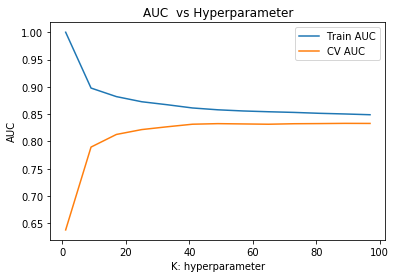

In [55]:
# Please write all the code with proper documentation
#finding the best hyper parameter  using simple loop method 
# Reference ,code re-using from sample solution ipynb
#finding the best hyperperameter using train and cv data 
train_auc = []
cv_auc = []
K = list(range(1,100,8))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(final_tfidfw2v_train_data, y_tfidfw2v_train_data)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(final_tfidfw2v_train_data)[:,1]
    y_cv_pred =  neigh.predict_proba(final_tfidfw2v_cv_data)[:,1]
    train_auc_score=roc_auc_score(y_tfidfw2v_train_data,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_tfidfw2v_cv_data, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("k = ",i,"CV:",cv_auc_score,"Train:",train_auc_score)


plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC  vs Hyperparameter")
plt.show()


There is not much change after k=17 on tfidfw2v data so here we consider optimal k as k=17 

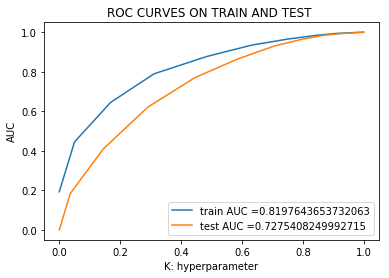

In [86]:
#applying  knn brute version on tfidfw2v data

neigh = KNeighborsClassifier(n_neighbors=17,algorithm = 'brute')
neigh.fit(final_tfidfw2v_train_data, y_tfidfw2v_train_data)


tfidfw2v_train_fpr, tfidfw2v_train_tpr, tfidfw2v_thresholds = roc_curve(y_tfidfw2v_train_data, neigh.predict_proba(final_tfidfw2v_train_data)[:,1])
tfidfw2v_test_fpr, tfidfw2v_test_tpr, tfidfw2v_thresholds = roc_curve(y_tfidfw2v_test_data, neigh.predict_proba(final_tfidfw2v_test_data)[:,1])

plt.plot(tfidfw2v_train_fpr, tfidfw2v_train_tpr, label="train AUC ="+str(auc(tfidfw2v_train_fpr, tfidfw2v_train_tpr)))
plt.plot(tfidfw2v_test_fpr, tfidfw2v_test_tpr, label="test AUC ="+str(auc(tfidfw2v_test_fpr, tfidfw2v_test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

tfidfw2v Test confusion matrix
[[  71   35]
 [ 906 4988]]


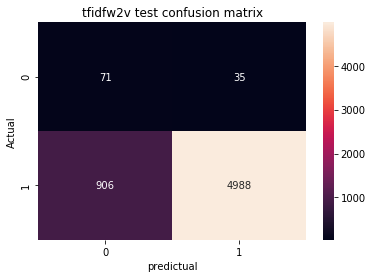

In [87]:
#avgw2v Test data confusion matrix
print("tfidfw2v Test confusion matrix")
tfidfw2v_cm_test = confusion_matrix(neigh.predict(final_tfidfw2v_test_data),y_tfidfw2v_test_data)
sns.heatmap(tfidfw2v_cm_test, annot=True, fmt="d")
plt.title("tfidfw2v test confusion matrix")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidfw2v_cm_test)

<h2><b>OBSERVATIONS IN TFIDFW2V</b></h2><br>
here we got confsion matrix 5059 are correctly predicted and 941 are wrongly predicted out of 13822 positive and negative  and we got test auc as 0.72 train is0.81  

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [58]:
x_bow_dense=final['CleanedText'][:20000,] #taking 20k data
y_bow_dense=final['Score'][:20000,]
#splitted the data in to train and test
x_bow_train_dense,x_bow_test_data_dense,y_bow_train_dense,y_bow_test_data_dense = train_test_split(x_bow_dense, y_bow_dense, test_size=0.3, random_state=0)
#splitted the above train data into 2nd train and cross validation 
x_bow_train_data_dense,x_bow_cv_data_dense,y_bow_train_data_dense,y_bow_cv_data_dense = train_test_split(x_bow_train_dense, y_bow_train_dense, test_size=0.3, random_state=0)

print("Data splitted sucessfully in to train ,test,cv")

Data splitted sucessfully in to train ,test,cv


In [59]:
print("x_bow_train_data_dense,y_bow_train_data_dense\n",x_bow_train_data_dense.shape,y_bow_train_data_dense.shape)
print()
print("x_bow_cv_data_dense,y_bow_cv_data_dense\n",x_bow_cv_data_dense.shape,y_bow_cv_data_dense.shape)
print()
print("x_bow_test_data_dense,y_bow_test_data_dense\n",x_bow_test_data_dense.shape,y_bow_test_data_dense.shape)
print()

x_bow_train_data_dense,y_bow_train_data_dense
 (9800,) (9800,)

x_bow_cv_data_dense,y_bow_cv_data_dense
 (4200,) (4200,)

x_bow_test_data_dense,y_bow_test_data_dense
 (6000,) (6000,)



In [60]:
#bow dense
count_vect = CountVectorizer(max_features=500) #in scikit-learn
final_counts_bow_train = count_vect.fit_transform(x_bow_train_data_dense.values)
final_bow_train_data=final_counts_bow_train
final_bow_train_data_dense=final_bow_train_data.todense()

#transform  on testdata
final_bow_test_data = count_vect.transform(x_bow_test_data_dense)
final_bow_test_data_dense=final_bow_test_data.todense()

#transform on cv data 
final_bow_cv_data = count_vect.transform(x_bow_cv_data_dense)
final_bow_cv_data_dense=final_bow_cv_data.todense()



#print("the type of count vectorizer ",type(final_bow_train_data_dense))
#print("the shape of out text BOW vectorizer ",final_bow_train_data_dense.get_shape())
#print("the number of unique words ", final_bow_train_data_dense.get_shape()[1])
#dense_bow=final_bow_train_data.todense()
print('-' * 50 )
print("here below  we converting scipy to dense for knn ")
print('-' * 50 )
#print("the type of count vectorizer ",type(dense_bow))

#print(final_bow_train_data_dense.shape,y_bow_train_data_dense.shape)
#print(final_bow_test_data_dense.shape,y_bow_test_data_dense.shape)
#print(final_bow_cv_data_dense.shape,y_bow_cv_data_dense.shape)
print("Bow splitted data\n", "final_bow_train_data_dense,y_bow_train_data_dense\n","final_bow_test_data_dense,y_bow_test_data_dense\n","final_bow_cv_data_dense,y_bow_cv_data_dense\n")

--------------------------------------------------
here below  we converting scipy to dense for knn 
--------------------------------------------------
Bow splitted data
 final_bow_train_data_dense,y_bow_train_data_dense
 final_bow_test_data_dense,y_bow_test_data_dense
 final_bow_cv_data_dense,y_bow_cv_data_dense



k =  1 CV: 0.5836881838147883 Train: 1.0
k =  9 CV: 0.7057014789541202 Train: 0.8755739280174354
k =  17 CV: 0.7413757060629061 Train: 0.8524149624013387
k =  25 CV: 0.7504573457407867 Train: 0.8429481627960951
k =  33 CV: 0.7610501783207625 Train: 0.834486205700691
k =  41 CV: 0.7634309368052712 Train: 0.8261447943422842
k =  49 CV: 0.7703696209928201 Train: 0.8232939030380217
k =  57 CV: 0.7705931516095883 Train: 0.8200667291382648
k =  65 CV: 0.7735053462646668 Train: 0.8206918295129637
k =  73 CV: 0.7769093082766356 Train: 0.8200300580180174
k =  81 CV: 0.7758132736468107 Train: 0.8175890837224739
k =  89 CV: 0.7818723176325987 Train: 0.8176478574571262
k =  97 CV: 0.7825015615659988 Train: 0.8176594661346049


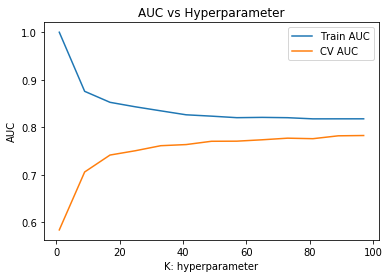

In [61]:
#finding the best hyperperameter using bow dense data with train and cv
train_auc = []
cv_auc = []
K = list(range(1,100,8))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(final_bow_train_data_dense, y_bow_train_data_dense)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(final_bow_train_data_dense)[:,1]
    y_cv_pred =  neigh.predict_proba(final_bow_cv_data_dense)[:,1]
    train_auc_score=roc_auc_score(y_bow_train_data_dense,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_bow_cv_data_dense, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("k = ",i,"CV:",cv_auc_score,"Train:",train_auc_score)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

The optimal k is 9 there is n much value changed in after k=9 so here we consider optimal k=9 for bow data in kd-tree

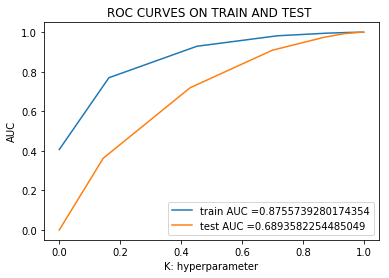

In [97]:
#applying  knn k-d tree version on dense bow data
from sklearn.metrics import roc_curve, auc

neigh = KNeighborsClassifier(n_neighbors=9,algorithm = 'kd_tree')
neigh.fit(final_bow_train_data_dense, y_bow_train_data_dense)


bow_train_fpr_dense, bow_train_tpr_dense, bow_thresholds_dense = roc_curve(y_bow_train_data_dense, neigh.predict_proba(final_bow_train_data_dense)[:,1])
bow_test_fpr_dense, bow_test_tpr_dense, bow_thresholds_dense = roc_curve(y_bow_test_data_dense, neigh.predict_proba(final_bow_test_data_dense)[:,1])

plt.plot(bow_train_fpr_dense, bow_train_tpr_dense, label="train AUC ="+str(auc(bow_train_fpr_dense, bow_train_tpr_dense)))
plt.plot(bow_test_fpr_dense, bow_test_tpr_dense, label="test AUC ="+str(auc(bow_test_fpr_dense, bow_test_tpr_dense)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

Test confusion matrix
[[  62   36]
 [ 915 4987]]


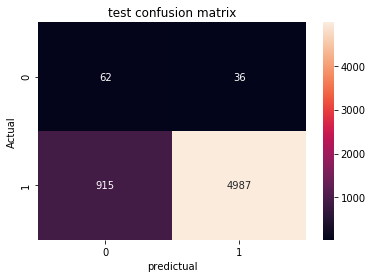

In [98]:
#Test data confusion matrix
print("Test confusion matrix")
cm_test_dense = confusion_matrix(neigh.predict(final_bow_test_data_dense),y_bow_test_data_dense)
sns.heatmap(cm_test_dense, annot=True, fmt="d")
plt.title("test confusion matrix")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(cm_test_dense)

<h2><b>OBSERVATIONS</b></h2><br>
Here in confusion matrix we get 5049 are correctly predicted and 951 are in-correctly predicted and we got train auc is 0.87 and test auc is 0.68


### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [64]:
# Please write all the code with proper documentation
#splitting the data 
x_tfidf_dense=final['CleanedText'][:20000,] #taking whole data
y_tfidf_dense=final['Score'][:20000,]
#splitted the data in to train and test
x_tfidf_train_dense,x_tfidf_test_data_dense,y_tfidf_train_dense,y_tfidf_test_data_dense = train_test_split(x_tfidf_dense, y_tfidf_dense, test_size=0.3, random_state=0)
#splitted the above train data into 2nd train and cross validation 
x_tfidf_train_data_dense,x_tfidf_cv_data_dense,y_tfidf_train_data_dense,y_tfidf_cv_data_dense = train_test_split(x_tfidf_train_dense, y_tfidf_train_dense, test_size=0.3, random_state=0)

print("Data splitted sucessfully in to train ,test,cv")

print(x_tfidf_train_data_dense.shape,y_tfidf_train_data_dense.shape)
print(x_tfidf_cv_data_dense.shape,y_tfidf_cv_data_dense.shape)
print(x_tfidf_test_data_dense.shape,y_tfidf_test_data_dense.shape)


Data splitted sucessfully in to train ,test,cv
(9800,) (9800,)
(4200,) (4200,)
(6000,) (6000,)


In [65]:
#tfidf vectorizer 20k sample for dence 
tf_idf_vect_dense = TfidfVectorizer(ngram_range=(1,2),max_features=500)

final_tfidf_train_data = tf_idf_vect_dense.fit_transform(x_tfidf_train_data_dense.values)
final_tfidf_train_data_dense=final_tfidf_train_data.todense()

final_tfidf_test_data = tf_idf_vect_dense.transform(x_tfidf_test_data_dense)
final_tfidf_test_data_dense=final_tfidf_test_data.todense()

final_tfidf_cv_data = tf_idf_vect_dense.transform(x_tfidf_cv_data_dense)
final_tfidf_cv_data_dense=final_tfidf_cv_data.todense()
print("final data after converted to dence")
print("-"*50)
print("final_tfidf_train_data_dense,y_tfidf_train_data_dense")
print("final_tfidf_test_data_dense,y_tfidf_test_data_dense")
print("final_tfidf_cv_data_dense,y_tfidf_cv_data_dense")

final data after converted to dence
--------------------------------------------------
final_tfidf_train_data_dense,y_tfidf_train_data_dense
final_tfidf_test_data_dense,y_tfidf_test_data_dense
final_tfidf_cv_data_dense,y_tfidf_cv_data_dense


k =  1 CV: 0.5617901591118216 Train: 1.0
k =  9 CV: 0.7488311342678103 Train: 0.8904478727713551
k =  17 CV: 0.7723805569921216 Train: 0.8655326526343126
k =  25 CV: 0.7784540832432215 Train: 0.8534294147435277
k =  33 CV: 0.7877460305999772 Train: 0.8488544041976978
k =  41 CV: 0.7928962599654775 Train: 0.8450351877465259
k =  49 CV: 0.7981839659074881 Train: 0.8413300976643419
k =  57 CV: 0.8030050910409768 Train: 0.8413800303532321
k =  65 CV: 0.808377171920021 Train: 0.8413442433375609
k =  73 CV: 0.8112482285460981 Train: 0.8407370172510331
k =  81 CV: 0.8138470605618952 Train: 0.842075051868109
k =  89 CV: 0.815022642706983 Train: 0.8420655957930769
k =  97 CV: 0.8195310348648994 Train: 0.8429617318793736


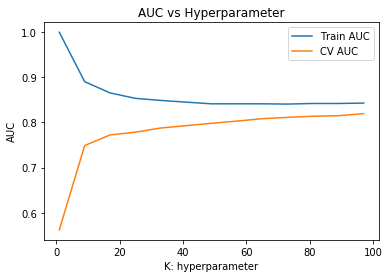

In [66]:
#finding the best hyperperameter on dense tfidf with train and cv data 
train_auc = []
cv_auc = []
K = list(range(1,100,8))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(final_tfidf_train_data_dense, y_tfidf_train_data_dense)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(final_tfidf_train_data_dense)[:,1]
    y_cv_pred =  neigh.predict_proba(final_tfidf_cv_data_dense)[:,1]
    train_auc_score=roc_auc_score(y_tfidf_train_data_dense,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_tfidf_cv_data_dense, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("k = ",i,"CV:",cv_auc_score,"Train:",train_auc_score)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

Here for tfidf data we get optimal k is 9 

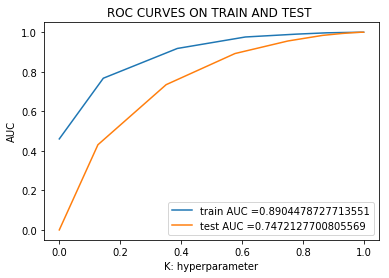

In [90]:
#applying  knn k-dtree version on tfidf dense data

neigh = KNeighborsClassifier(n_neighbors=9,algorithm = 'kd_tree')
neigh.fit(final_tfidf_train_data_dense, y_tfidf_train_data_dense)


tfidf_train_fpr_dense, tfidf_train_tpr_dense, tfidf_thresholds_dense = roc_curve(y_tfidf_train_data_dense, neigh.predict_proba(final_tfidf_train_data_dense)[:,1])
tfidf_test_fpr_dense, tfidf_test_tpr_dense, tfidf_thresholds_dense = roc_curve(y_tfidf_test_data_dense, neigh.predict_proba(final_tfidf_test_data_dense)[:,1])

plt.plot(tfidf_train_fpr_dense, tfidf_train_tpr_dense, label="train AUC ="+str(auc(tfidf_train_fpr_dense, tfidf_train_tpr_dense)))
plt.plot(tfidf_test_fpr_dense, tfidf_test_tpr_dense, label="test AUC ="+str(auc(tfidf_test_fpr_dense, tfidf_test_tpr_dense)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

TFIDF Test confusion matrix
[[ 132   80]
 [ 845 4943]]


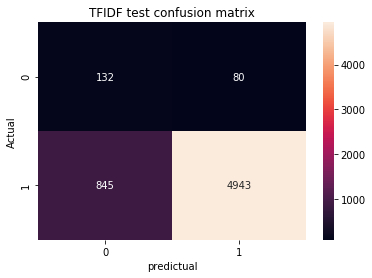

In [91]:
#TFIDf Test dense data confusion matrix
print("TFIDF Test confusion matrix")
tfidf_cm_test_dense = confusion_matrix(neigh.predict(final_tfidf_test_data_dense),y_tfidf_test_data_dense)
sns.heatmap(tfidf_cm_test_dense, annot=True, fmt="d")
plt.title("TFIDF test confusion matrix")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidf_cm_test_dense)

In confusion matrix we get 5075 are correctly predicted and 925 are in-correctly predicted and train auc is 0.89 and test auc is 0.74 which is average performance 

<h2><b>OBSERVATIONS</b></h2><br>
Here knn KD_Tree algorithm both train curve and test curve are closer to each other which says test performs more accurately be a good performance 

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [69]:
#avgw2v on kd-tree
x_avgw2v=final['CleanedText'][:20000,] #taking 20k data
y_avgw2v=final['Score'][:20000,]
#splitted the data in to train and test
x_avgw2v_train,x_avgw2v_test_data,y_avgw2v_train,y_avgw2v_test_data = train_test_split(x_avgw2v, y_avgw2v, test_size=0.3, random_state=0)
#splitted the above train data into 2nd train and cross validation 
x_avgw2v_train_data,x_avgw2v_cv_data,y_avgw2v_train_data,y_avgw2v_cv_data = train_test_split(x_avgw2v_train, y_avgw2v_train, test_size=0.3, random_state=0)

print("avgw2v Data splitted sucessfully in to train ,test,cv")

#train data
cleantext_train= x_avgw2v_train_data # building own text corpus from w2v train data  
i=0
list_of_sentance_train=[]
for sentance_train in cleantext_train:
    list_of_sentance_train.append(sentance_train.split())
print("cleantext train data")
    
#cv data
cleantext_cv= x_avgw2v_cv_data # building own text corpus from w2v train data  
j=0
list_of_sentance_cv=[]
for sentance_cv in cleantext_cv:
    list_of_sentance_cv.append(sentance_cv.split())
print("cleantext cv data")


#test data
cleantext_test= x_avgw2v_test_data # building own text corpus from w2v train data  
k=0
list_of_sentance_test=[]
for sentance_test in cleantext_test:
    list_of_sentance_test.append(sentance_test.split())
print("cleantext test data")



avgw2v Data splitted sucessfully in to train ,test,cv
cleantext train data
cleantext cv data
cleantext test data


In [70]:
#WORD2VEC USING OWN CORPUS FROM ABOVE DATA 
# min_count = 5 considers only words that occured atleast 5 times
w2v_train_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [71]:
w2v_words_train = list(w2v_train_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words from corpus  ", w2v_words_train[0:50])

number of words that occured minimum 5 times  4422
sample words from corpus   ['reason', 'stop', 'sell', 'store', 'worth', 'favorit', 'chicken', 'jack', 'link', 'famili', 'great', 'snack', 'anytim', 'wish', 'come', 'individu', 'wrap', 'stay', 'fresher', 'longer', 'contain', 'sort', 'would', 'ideal', 'still', 'tast', 'buy', 'price', 'mayb', 'constant', 'product', 'bit', 'annoy', 'use', 'protein', 'drink', 'year', 'better', 'tri', 'could', 'make', 'due', 'bake', 'chocol', 'harder', 'find', 'late', 'stock', 'unsur', 'difficult']


In [72]:
# average Word2Vec train data 
# compute average word2vec_train for each review.
sent_vectors_train = []; # the avg-w2v_train for each sentence/review is stored in this list
final_avgw2v_train_data=sent_vectors_train

for sent_train in tqdm(list_of_sentance_train): # for each train_review/sentence
    sent_vec_train = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_train =0; # num of words with a valid vector in the train_sentence/review
    for word_train in sent_train: # for each word in a train_review/sentence
        if word_train in w2v_words_train:
            vec_train = w2v_train_model.wv[word_train]
            sent_vec_train += vec_train
            cnt_words_train += 1
    if cnt_words_train != 0:
        sent_vec_train /= cnt_words_train
    sent_vectors_train.append(sent_vec_train)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))
print(type(final_avgw2v_train_data))

100%|█████████████████████████████████████| 9800/9800 [00:11<00:00, 845.46it/s]


9800
50
<class 'list'>


In [73]:
# average Word2Vec cv data 
# compute average word2vec_cv for each review.
sent_vectors_cv = []; # the avg-w2v_cv for each sentence/review is stored in this list
final_avgw2v_cv_data=sent_vectors_cv
for sent_cv in tqdm(list_of_sentance_cv): # for each cv_review/sentence
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_cv =0; # num of words with a valid vector in the cv_sentence/review
    for word_cv in sent_cv: # for each word in a cv_review/sentence
        if word_cv in w2v_words_train:
            vec_cv = w2v_train_model.wv[word_cv]
            sent_vec_cv += vec_cv
            cnt_words_cv += 1
    if cnt_words_cv != 0:
        sent_vec_cv /= cnt_words_cv
    sent_vectors_cv.append(sent_vec_cv)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))
print(type(sent_vectors_cv))

100%|█████████████████████████████████████| 4200/4200 [00:05<00:00, 809.14it/s]


4200
50
<class 'list'>


In [74]:
# average Word2Vec test data 
# compute average word2vec_test for each review.
sent_vectors_test = []; # the avg-w2v_test for each sentence/review is stored in this list
final_avgw2v_test_data=sent_vectors_test
for sent_test in tqdm(list_of_sentance_test): # for each train_review/sentence
    sent_vec_test = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_test =0; # num of words with a valid vector in the test_sentence/review
    for word_test in sent_test: # for each word in a test_review/sentence
        if word_test in w2v_words_train:
            vec_test = w2v_train_model.wv[word_test]
            sent_vec_test += vec_test
            cnt_words_test += 1
    if cnt_words_test != 0:
        sent_vec_test /= cnt_words_test
    sent_vectors_test.append(sent_vec_test)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))
print(type(sent_vectors_test))

100%|█████████████████████████████████████| 6000/6000 [00:06<00:00, 881.94it/s]


6000
50
<class 'list'>


k= 1 CV: 0.6002928356023616 Train: 1.0
k= 9 CV: 0.7448619441328775 Train: 0.8697764314787049
k= 17 CV: 0.7773595178287181 Train: 0.8465937103570391
k= 25 CV: 0.7840555716003197 Train: 0.833508309160761
k= 33 CV: 0.7884588099187986 Train: 0.8229536765335044
k= 41 CV: 0.7892217524464534 Train: 0.8189149330721304
k= 49 CV: 0.785556060219358 Train: 0.8156746513610482
k= 57 CV: 0.7879452142199894 Train: 0.8108057337026278
k= 65 CV: 0.7907142653251751 Train: 0.8083511134451472
k= 73 CV: 0.7908557297718434 Train: 0.8054973776305092
k= 81 CV: 0.7897263229654307 Train: 0.8028822731727845
k= 89 CV: 0.7886632407363875 Train: 0.7999091832403601
k= 97 CV: 0.7888093227169234 Train: 0.7972513726876725


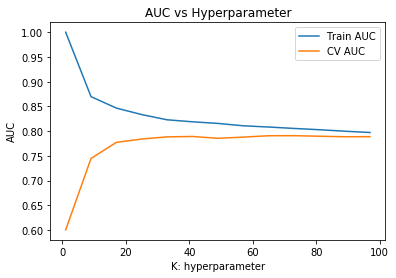

In [75]:
#finding the best hyper parameter  using simple loop method  on avgw2v
# Reference ,code re-using from sample solution ipynb
#finding the best hyper parameter using train and cv for avgw2v data 
train_auc = []
cv_auc = []
K = list(range(1,100,8))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(final_avgw2v_train_data, y_avgw2v_train_data)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(final_avgw2v_train_data)[:,1]
    y_cv_pred =  neigh.predict_proba(final_avgw2v_cv_data)[:,1]
    train_auc_score=roc_auc_score(y_avgw2v_train_data,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_avgw2v_cv_data, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("k=",i,"CV:",cv_auc_score,"Train:",train_auc_score)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs Hyperparameter")
plt.show()

Here we get optimal k is 9 after k=9 the cv-scores are similar so we take optimal k=9

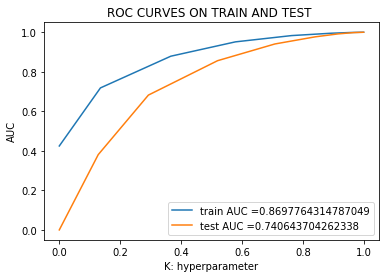

In [92]:
#applying  knn kd-tree version on avgw2v data

neigh = KNeighborsClassifier(n_neighbors=9,algorithm = 'kd_tree')
neigh.fit(final_avgw2v_train_data, y_avgw2v_train_data)


avgw2v_train_fpr, avgw2v_train_tpr, avgw2v_thresholds = roc_curve(y_avgw2v_train_data, neigh.predict_proba(final_avgw2v_train_data)[:,1])
avgw2v_test_fpr, avgw2v_test_tpr, avgw2v_thresholds = roc_curve(y_avgw2v_test_data, neigh.predict_proba(final_avgw2v_test_data)[:,1])

plt.plot(avgw2v_train_fpr, avgw2v_train_tpr, label="train AUC ="+str(auc(avgw2v_train_fpr, avgw2v_train_tpr)))
plt.plot(avgw2v_test_fpr, avgw2v_test_tpr, label="test AUC ="+str(auc(avgw2v_test_fpr, avgw2v_test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

avgw2v Test confusion matrix
[[ 155  116]
 [ 822 4907]]


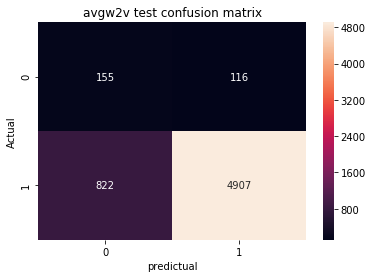

In [93]:
#avgw2v Test data confusion matrix
print("avgw2v Test confusion matrix")
avgw2v_cm_test = confusion_matrix(neigh.predict(final_avgw2v_test_data),y_avgw2v_test_data)
sns.heatmap(avgw2v_cm_test, annot=True, fmt="d")
plt.title("avgw2v test confusion matrix")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(avgw2v_cm_test)

<h2><b>OBSERVATIONS</b></h2><br>
Here we get train auc 0.86 and test auc 0.74  and confusion matrix says 5062 are correctly predicited 938 are in-correctly predicted both positive's and negatives overall this model performance is average 

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [78]:
x_tfidfw2v=final['CleanedText'][:20000,] #taking whole data
y_tfidfw2v=final['Score'][:20000,]
#splitted the whole data in to train and test
x_tfidfw2v_train,x_tfidfw2v_test_data,y_tfidfw2v_train,y_tfidfw2v_test_data = train_test_split(x_tfidfw2v, y_tfidfw2v, test_size=0.3, random_state=0)
#splitted the above train data into 2nd train and cross validation 
x_tfidfw2v_train_data,x_tfidfw2v_cv_data,y_tfidfw2v_train_data,y_tfidfw2v_cv_data = train_test_split(x_tfidfw2v_train, y_tfidfw2v_train, test_size=0.3, random_state=0)

print("tfidfw2v Data splitted sucessfully in to train ,test,cv")

#tfidfw2v train 
tfidfw2v_model_train = TfidfVectorizer(max_features=500)
final_tfidfw2v_train=tfidfw2v_model_train.fit(x_tfidfw2v_train_data)
dictionary_train = dict(zip(final_tfidfw2v_train.get_feature_names(), list(final_tfidfw2v_train.idf_)))

tfidfw2v Data splitted sucessfully in to train ,test,cv


In [79]:
# TF-IDF weighted Word2Vec
tfidf_feat_train = final_tfidfw2v_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = [];# the tfidf-w2v for each sentence/review is stored in this list
final_tfidfw2v_train_data=tfidf_sent_vectors_train
row=0;
for sent_train in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec_train = np.zeros(50) # as word vectors are of zero length
    weight_sum_train =0; # num of words with a valid vector in the sentence/review
    for word in sent_train: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_train:
            vec_train = w2v_train_model.wv[word]
             #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_train = dictionary_train[word]*(sent_train.count(word)/len(sent_train))
            sent_vec_train += (vec_train * tf_idf_train)
            weight_sum_train += tf_idf_train
    if weight_sum_train != 0:
        sent_vec_train /= weight_sum_train
    tfidf_sent_vectors_train.append(sent_vec_train)
    row += 1
print(len(sent_vec_train))
print(len(tfidf_sent_vectors_train))  
print(type(tfidf_sent_vectors_train))

100%|█████████████████████████████████████| 9800/9800 [00:14<00:00, 663.31it/s]


50
9800
<class 'list'>


In [80]:
#tfidfw2v cv data 
tfidfw2v_model_train = TfidfVectorizer(max_features=500)
final_tfidfw2v_train=tfidfw2v_model_train.fit(x_tfidfw2v_train_data)
dictionary_train = dict(zip(final_tfidfw2v_train.get_feature_names(), list(final_tfidfw2v_train.idf_)))


tfidf_feat_cv = final_tfidfw2v_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
final_tfidfw2v_cv_data=tfidf_sent_vectors_cv
row=0;
for sent_cv in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length
    weight_sum_cv =0; # num of words with a valid vector in the sentence/review
    for word_cv in sent_cv: # for each word in a review/sentence
        if word_cv in w2v_words_train and word_cv in tfidf_feat_cv:
            vec_cv = w2v_train_model.wv[word_cv]
             #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_cv = dictionary_train[word_cv]*(sent_cv.count(word_cv)/len(sent_cv))
            sent_vec_cv += (vec_cv * tf_idf_cv)
            weight_sum_cv += tf_idf_cv
    if weight_sum_cv != 0:
        sent_vec_cv /= weight_sum_cv
    tfidf_sent_vectors_cv.append(sent_vec_cv)
    row += 1
print(len(sent_vec_cv))
print(len(tfidf_sent_vectors_cv))  
print(type(tfidf_sent_vectors_cv))

100%|█████████████████████████████████████| 4200/4200 [00:06<00:00, 647.73it/s]


50
4200
<class 'list'>


In [81]:
#tfidfw2v test data 
tfidfw2v_model_train = TfidfVectorizer(max_features=500)
final_tfidfw2v_train=tfidfw2v_model_train.fit(x_tfidfw2v_train_data)
dictionary_train = dict(zip(final_tfidfw2v_train.get_feature_names(), list(final_tfidfw2v_train.idf_)))


tfidf_feat_test = final_tfidfw2v_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
final_tfidfw2v_test_data=tfidf_sent_vectors_test
row=0;
for sent_test in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec_test = np.zeros(50) # as word vectors are of zero length
    weight_sum_test =0; # num of words with a valid vector in the sentence/review
    for word_test in sent_test: # for each word in a review/sentence
        if word_test in w2v_words_train and word_test in tfidf_feat_test:
            vec_test = w2v_train_model.wv[word_test]
             #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_test = dictionary_train[word_test]*(sent_test.count(word_test)/len(sent_test))
            sent_vec_test += (vec_test * tf_idf_test)
            weight_sum_test += tf_idf_test
    if weight_sum_test != 0:
        sent_vec_test /= weight_sum_test
    tfidf_sent_vectors_test.append(sent_vec_test)
    row += 1
print(len(sent_vec_test))
print(len(tfidf_sent_vectors_test))  
print(type(tfidf_sent_vectors_test))  

100%|█████████████████████████████████████| 6000/6000 [00:09<00:00, 622.74it/s]


50
6000
<class 'list'>


k= 1 CV: 0.5679902477684717 Train: 1.0
k= 9 CV: 0.7007615572674947 Train: 0.8447392817888064
k= 17 CV: 0.7337085009638051 Train: 0.8197643653732063
k= 25 CV: 0.7381096404032534 Train: 0.8075517675902792
k= 33 CV: 0.7426312554990631 Train: 0.7971784148404718
k= 41 CV: 0.7431639509970516 Train: 0.7908547223215879
k= 49 CV: 0.7388255680406209 Train: 0.7832687206645453
k= 57 CV: 0.7392680117402899 Train: 0.7806171757225498
k= 65 CV: 0.7413488404113131 Train: 0.7776946719476157
k= 73 CV: 0.7440576536883182 Train: 0.776656233463881
k= 81 CV: 0.7418357803464326 Train: 0.7735058997835943
k= 89 CV: 0.7411104077534271 Train: 0.7701319645241892
k= 97 CV: 0.7421946886606802 Train: 0.7677851281463457


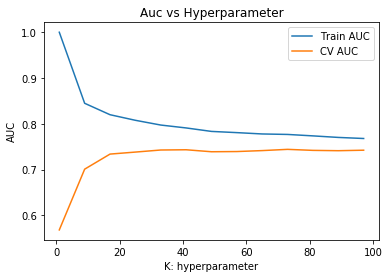

In [82]:
#finding the best hyperparameter using train and cv for tfidfw2v data
train_auc = []
cv_auc = []
K = list(range(1,100,8))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(final_tfidfw2v_train_data, y_tfidfw2v_train_data)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(final_tfidfw2v_train_data)[:,1]
    y_cv_pred =  neigh.predict_proba(final_tfidfw2v_cv_data)[:,1]
    train_auc_score=roc_auc_score(y_tfidfw2v_train_data,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_tfidfw2v_cv_data, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("k=",i,"CV:",cv_auc_score,"Train:",train_auc_score)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Auc vs Hyperparameter")
plt.show()


Here we get optial k is 9 afterk=9 ther is not much change in cv_auc_scores so we consider k=9 as optimal k 

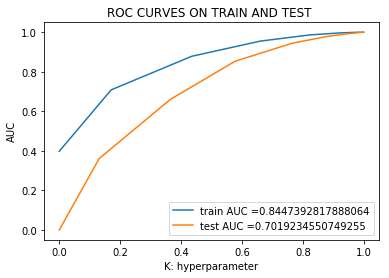

In [94]:
#applying  knn brute version on tfidfw2v data

neigh = KNeighborsClassifier(n_neighbors=9,algorithm = 'kd_tree')
neigh.fit(final_tfidfw2v_train_data, y_tfidfw2v_train_data)


tfidfw2v_train_fpr, tfidfw2v_train_tpr, tfidfw2v_thresholds = roc_curve(y_tfidfw2v_train_data, neigh.predict_proba(final_tfidfw2v_train_data)[:,1])
tfidfw2v_test_fpr, tfidfw2v_test_tpr, tfidfw2v_thresholds = roc_curve(y_tfidfw2v_test_data, neigh.predict_proba(final_tfidfw2v_test_data)[:,1])

plt.plot(tfidfw2v_train_fpr, tfidfw2v_train_tpr, label="train AUC ="+str(auc(tfidfw2v_train_fpr, tfidfw2v_train_tpr)))
plt.plot(tfidfw2v_test_fpr, tfidfw2v_test_tpr, label="test AUC ="+str(auc(tfidfw2v_test_fpr, tfidfw2v_test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

tfidfw2v Test confusion matrix
[[ 119  109]
 [ 858 4914]]


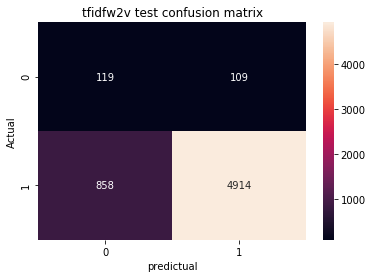

In [95]:
#avgw2v Test data confusion matrix
print("tfidfw2v Test confusion matrix")
tfidfw2v_cm_test = confusion_matrix(neigh.predict(final_tfidfw2v_test_data),y_tfidfw2v_test_data)
sns.heatmap(tfidfw2v_cm_test, annot=True, fmt="d")
plt.title("tfidfw2v test confusion matrix")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidfw2v_cm_test)

<h2><b>OBSERVATIONS</b></h2><br>
confusion matrix says 5033 are correctly predicited and 967 are in-correctly predicted ,and train auc is 0.84 and test auc is 0.70 here test auc gives a not much average performance 

# [6] Conclusions

In [100]:
# compare all your models using Prettytable library
#ref : http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Best K", "Auc"]

x.add_row(["BOW", "brute",9,0.71])
x.add_row(["TF-IDf","brute",17,0.81 ])
x.add_row(["AVGW2V", "brute",9,0.82])
x.add_row(["TFIDFW2V", "brute",17,0.72])
x.add_row(["BOW", "k-dtree",9,0.68])
x.add_row(["TF-IDf", "k-dtree",9,0.74])
x.add_row(["AVGW2V", "k-dtree",9,0.74])
x.add_row(["TFIDFW2V", "k-dtree",9,0.70])

print(x)
print("#"*50)

x1 = PrettyTable()
x1.field_names = ["Best Vectorizer", "Best Model", "Best K", "Best Auc"]
x1.add_row(["AVGW2V", "brute",9,0.82])
print(x1)

+------------+---------+--------+------+
| Vectorizer |  Model  | Best K | Auc  |
+------------+---------+--------+------+
|    BOW     |  brute  |   9    | 0.71 |
|   TF-IDf   |  brute  |   17   | 0.81 |
|   AVGW2V   |  brute  |   9    | 0.82 |
|  TFIDFW2V  |  brute  |   17   | 0.72 |
|    BOW     | k-dtree |   9    | 0.68 |
|   TF-IDf   | k-dtree |   9    | 0.74 |
|   AVGW2V   | k-dtree |   9    | 0.74 |
|  TFIDFW2V  | k-dtree |   9    | 0.7  |
+------------+---------+--------+------+
##################################################
+-----------------+------------+--------+----------+
| Best Vectorizer | Best Model | Best K | Best Auc |
+-----------------+------------+--------+----------+
|      AVGW2V     |   brute    |   9    |   0.82   |
+-----------------+------------+--------+----------+


<h3>conclusions</h3>
<p>1.Here we get better vectorization is avgw2v with brute force algorithm with optimal k=9<br>
   2.Most of optimal k value is 9 only for tfidf and tfidf w2v k=17 these both vectorizers got same optimal k values <br>
    3.Avgw2v gives a better results next tf-idf which also gives 0.81 is also a good model <br>
    4.So finally here brute model gives better results compare to kd-tree 
    
</p>